# Data Engineering Capstone Project

## Project Summary

The goal of the work presented in this notebook is to design an extract-transform-load (ETL) pipeline to process I94 inmigration data, global land temperature data and US demographic information. In industry, ETLs like this are widely used to wrangle and enrich raw data before ingesting it into an analytics workspace. The end objective of our use-case is to find patterns that relate the immigration to the US with the global land temperature.

This project is organized as follows:

* Step 1: Scope of the project and data gatherig
* Step 2: Exploratory data analysis (EDA)
* Step 3: Data model definition
* Step 4: Run the ETL to model the data
* Step 5: Project write-up

## Preliminar set-up

### Python dependencies

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import configparser
import datetime as dt

from lib_spark import *

### AWS credentials

In [2]:
config = configparser.ConfigParser()
config.read('config.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

### Spark Session

In [3]:
spark = SparkSession.builder.\
    config("spark.jars.repositories", "https://repos.spark-packages.org/").\
    config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

## Step 1: Scope of the project and data gatherig

### Project Scope 

We are going to use the Python API of [Apache Spark](https://spark.apache.org/) ([PySpark](https://spark.apache.org/docs/latest/api/python/index.html)) due to the efficiency and easy of use of this data processing framework. We will load the corresponding data as Spark dataframes with the purpose to perform EDA on them lo locate the missing/duplicate values and clean the raw data. This stage is very important since the validity of future insights depends on the data quality.

Once the raw data is clean, We will proceed to re-organize it by constructing a database with the shape of a [star-schema](https://www.guru99.com/star-snowflake-data-warehousing.html). A star-schema is a widely used structure to organize the data hosted in Data Warehouses. They are characterized by a *fact* table that in our case will encapsulate the immigration dataset and by a set of *dimension* tables connected to the previous one by foreign keys. The *dimension* tables provide additional details that enrich the information already present in the fact table. In this use-case, the *dimension* tables will be the *immigration calendar*, the *country* and the *demographics* tables.

In short, we will go through the following steps. 

1. The data will be loaded as PySpark [dataframes](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.html).
2. EDA on the I94 immigration dataset
3. EDA on the demographics dataset
4. EDA on the global land temperatures dataset
5. Once we know the distribution of missing values (NaNs or NULLs) we will proceed to clean the datasets mentioned above
6. Create the fact and dimension tables

As mentioned previously, to code the pipeline and carry out the required computations we will use Python and Apache Spark. In adition, one can make use of cloud providers like Amazon to scale out the storage and computational capabilities of the work presented here by making use of S3 and EMR. In this notebook we outline the logic of the ETL that can be also found in the script `./etl.py`.

### Dataset description

#### I94 Inmigration dataset

This dataset contains inmigration data gathered from the US National Tourism and Trade Office. The I-94 paper is a form used by U.S. Customs and Border Protection (CBP) to keep track on non-US citizens entering the country. This dataset will conform the main part of our DWH since our end goal is to conform a workspace where one can look for patterns and correlations between inmigration and global land temperatures or, in other words, the I94 Inmigration dataset will be the *fact* table. The I94 Inmigration dataset can be found at `../../data/18-83510-I94-Data-2016/` organized by months stored individually in *sas7bdat* format.

```
data
├── 18-83510-I94-Data-2016
│   ├── i94_apr16_sub.sas7bdat
│   ├── i94_aug16_sub.sas7bdat
│   ├── i94_dec16_sub.sas7bdat
│   ├── i94_feb16_sub.sas7bdat
│   ├── i94_jan16_sub.sas7bdat
│   ├── i94_jul16_sub.sas7bdat
│   ├── i94_jun16_sub.sas7bdat
│   ├── i94_mar16_sub.sas7bdat
│   ├── i94_may16_sub.sas7bdat
│   ├── i94_nov16_sub.sas7bdat
│   ├── i94_oct16_sub.sas7bdat
│   └── i94_sep16_sub.sas7bdat
└── I94_SAS_Labels_Descriptions.SAS
```

##### Loading I94 Inmigration dataset

In [4]:
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
df_inmigration =spark.read.format('com.github.saurfang.sas.spark').load(fname)

Let's take a look to the dataframe to have a quick understanding on the datatypes and shape of the dataframe

In [5]:
df_inmigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [6]:
df_inmigration.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [7]:
records = df_inmigration.count()
print(f"Number of records in I94 raw dataset: {records}")

Number of records in I94 raw dataset: 3096313


##### I94 Inmigration dataset dictionary

<table align="left">
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
 <tr><td>cicid</td><td>Unique ID</td>
 <tr><td>i94yr</td><td>Year</td>
 <tr><td>i94mon</td><td>Month</td>
 <tr><td>i94cit</td><td>3 digit code for immigrant country of birth</td>
 <tr><td>i94res</td><td>3 digit code for immigrant country of residence </td>
 <tr><td>i94port</td><td>Port of admission</td>
 <tr><td>arrdate</td><td>Arrival date to the USA</td>
 <tr><td>i94mode</td><td>Transport used: 1 = air, 2 = sea, 3 = land, 4 = not reported</td>
 <tr><td>i94addr</td><td>USA State of arrival</td>
 <tr><td>depdate</td><td>Departure date from the USA</td>
 <tr><td>i94bir</td><td>Age of respondent (in years)</td>
 <tr><td>i94visa</td><td>Visa codes collapsed into three categories</td>
 <tr><td>count</td><td>Field used for summary statistics</td>
 <tr><td>dtadfile</td><td>Date added to I-94 Files</td>
 <tr><td>visapost</td><td>Department of State where where Visa was issued</td>
 <tr><td>occup</td><td>Occupation in the in USA</td>
 <tr><td>entdepa</td><td>Arrival Flag</td>
 <tr><td>entdepd</td><td>Departure Flag</td>
 <tr><td>entdepu</td><td>Update Flag</td>
 <tr><td>matflag</td><td>Match flag</td>
 <tr><td>biryear</td><td>Year of birth</td>
 <tr><td>dtaddto</td><td>Admission deadline in the USA</td>
 <tr><td>gender</td><td>Non-immigrant sex</td>
 <tr><td>insnum</td><td>INS number</td>
 <tr><td>airline</td><td>Airline used to arrive to the USA</td>
 <tr><td>admnum</td><td>Admission number</td>
 <tr><td>fltno</td><td>Flight number of Airline used to arrive to the USA</td>
 <tr><td>visatype</td><td>Class/type of visa admission</td>
</table>

#### World temperature dataset

This dataset can be found in [Kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data). The data originates from the [Berkeley Earth](http://berkeleyearth.org/about/) in collaboration with the Lawrence Berkeley National Laboratory. The whole raw dataset that can be found in [here](http://berkeleyearth.org/data/) combines temperature related information published in 1.6 billion reports. The original dataset has both land and ocean data. In our case, we will work with the land subset of this data that can be found in `../../data2/GlobalLandTemperaturesByCity.csv`.

##### Loading the world temperature dataset

In [8]:
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temperature = spark.read.csv(fname, header=True, inferSchema=True)

Let's take a look to the dataframe to have a quick understanding of the datatypes and shape of the dataframe

In [9]:
df_temperature.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [10]:
df_temperature.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [11]:
records = df_temperature.count()
print(f"Number of records in the world temperature dataset: {records}")

Number of records in the world temperature dataset: 8599212


##### World temperature dataset dictionary

<table align="left">
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
 <tr><td>dt</td><td>Date</td>
 <tr><td>AverageTemperature</td><td>Global average land temperature (Celsius)</td>
 <tr><td>AverageTemperatureUncertainty</td><td>Confidence interval (95%)</td>
 <tr><td>City</td><td>City</td>
 <tr><td>Country</td><td>Country</td>
 <tr><td>Latitude</td><td>City latitude</td>
 <tr><td>Longitude</td><td>City longitude</td>
</table>

#### USA City Demographic dataset 

This dataset was obtained from [OpenSoft](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/). It contains information about the demographics of all US cities and towns with a population greater or equal to 65,000 people.

##### Loading the USA City Demographic dataset

In [12]:
fname = "us-cities-demographics.csv"
df_demographics = spark.read.csv(fname, inferSchema=True, header=True, sep=';')

Let's take a look to the dataframe to have a quick understanding of the datatypes and shape of the dataframe

In [13]:
df_demographics.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



In [14]:
df_demographics.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [15]:
records = df_demographics.count()
print(f"Number of records in the USA City Demographic dataset: {records}")

Number of records in the USA City Demographic dataset: 2891


##### USA City Demographic dictionary

<table align="left">
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
 <tr><td>City</td><td>City</td>
 <tr><td>State</td><td>State</td>
 <tr><td>Median Age</td><td>Median age of the population</td>
 <tr><td>Male Population</td><td>Count of male population</td>
 <tr><td>Female Population</td><td>Count of female population</td>
 <tr><td>Total Population</td><td>Count of total population</td>
 <tr><td>Number of Veterans</td><td>Count of total veterans</td>
 <tr><td>Foreign born</td><td>Number of residents not born in the city</td>
 <tr><td>Average Household Size</td><td>Average city household size</td>
 <tr><td>State Code</td><td>State code</td>
 <tr><td>Race</td><td>Respondent race</td>
 <tr><td>Count</td><td>Count of city's individual per race</td>
</table>

## Step 2: Explore and Assess the Data

In this step we will clean the data from duplicate records and NaNs. We will apply the following approach for removing NaNs and duplicates:

1. Rows with 100% of NaN values will be dropped

2. Columns with the higher amount of NaN values will be dropped

One approach to identify the NaNs present in the columns is to visualize the ammount of them. This way we will easily identify the columns that do not add much information to the dataset.

### EDA on the I94 immigration dataset

Before cleaning the data, let's take a quick look on how the information is organized at:

1. **Folder structure**:

In [16]:
os.listdir('../../data/18-83510-I94-Data-2016/')

['i94_apr16_sub.sas7bdat',
 'i94_sep16_sub.sas7bdat',
 'i94_nov16_sub.sas7bdat',
 'i94_mar16_sub.sas7bdat',
 'i94_jun16_sub.sas7bdat',
 'i94_aug16_sub.sas7bdat',
 'i94_may16_sub.sas7bdat',
 'i94_jan16_sub.sas7bdat',
 'i94_oct16_sub.sas7bdat',
 'i94_jul16_sub.sas7bdat',
 'i94_feb16_sub.sas7bdat',
 'i94_dec16_sub.sas7bdat']

2. **I94 dataset schema**:

In [17]:
df_inmigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

#### Missing values visualization

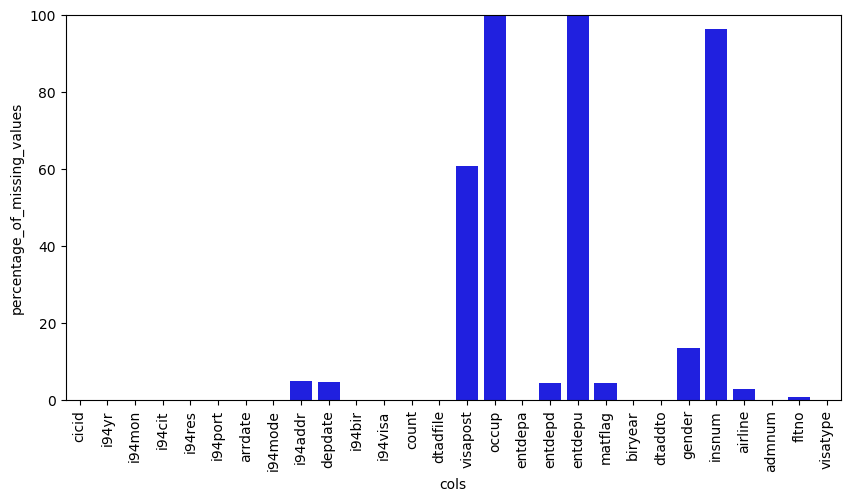

In [18]:
plot_nan_values(df_inmigration)

We can see that the columns *occup*, *entdepu* and *insnum* have over 90% of NaN values. These columns will be cleaned-up since they do not add relevant information.

#### Clean-up

In [20]:
# Dropping NaN columns

nan_columns = ['occup', 'entdepu','insnum']
clean_df_inmigration = df_inmigration.drop(*nan_columns)

In [21]:
# Dropping duplicate rows found for the unique identifier 'cicid'

clean_df_inmigration = clean_df_inmigration.dropDuplicates(['cicid'])

In [22]:
clean_df_inmigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)



In [23]:
print(f'Number of records present in the raw inmigration dataset: {df_inmigration.count()}')
print(f'Number of records after cleaning: {clean_df_inmigration.count()}')

Number of records present in the raw inmigration dataset: 3096313
Number of records after cleaning: 3096313


### EDA on the World temperature dataset

Let's take a look into the dataset schema

In [24]:
df_temperature.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



#### Missing values visualization

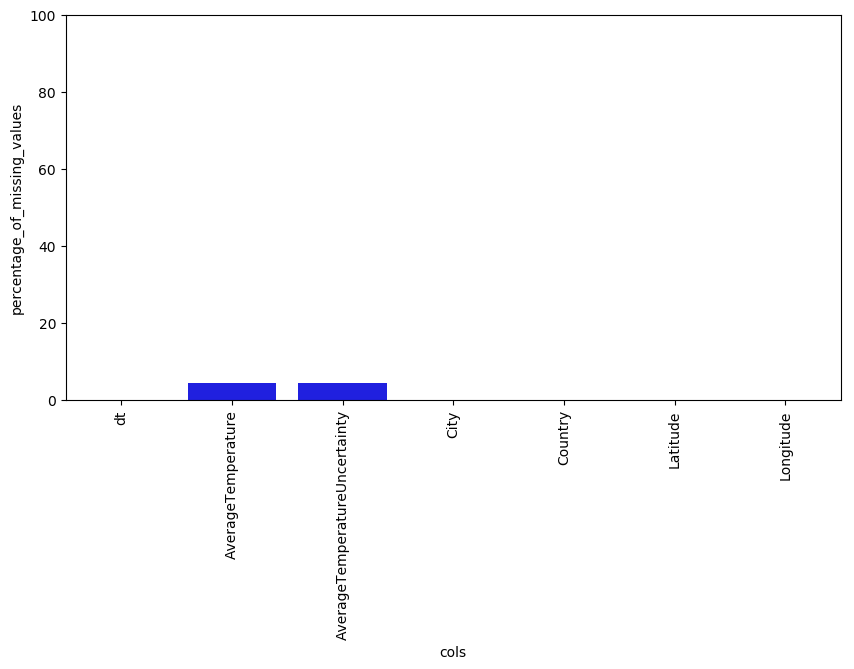

In [25]:
df_temperature = df_temperature.withColumn("dt",col("dt").cast(StringType()))
plot_nan_values(df_temperature)

We can see that the columns *AverageTemperature* and *AverageTemperatureUncertainty* are the only ones with sizable NaN records. These columns will be cleaned-up.

#### Clean-up

In [27]:
# Dropping NaN columns

nan_columns = ['AverageTemperature', 'AverageTemperatureUncertainty']
clean_df_temperature = df_temperature.dropna(subset=nan_columns)

In [28]:
# Dropping duplicate rows

duplicate_columns = ['dt', 'City', 'Country']
clean_df_temperature = clean_df_temperature.dropDuplicates(duplicate_columns)

In [29]:
clean_df_temperature.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [30]:
print(f'Number of records present in the raw temperature dataset: {df_temperature.count()}')
print(f'Number of records after cleaning: {clean_df_temperature.count()}')

Number of records present in the raw temperature dataset: 8599212
Number of records after cleaning: 8190783


### EDA on the demographics dataset

Let's take a look into the dataset schema

In [31]:
df_demographics.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



#### Missing values visualization

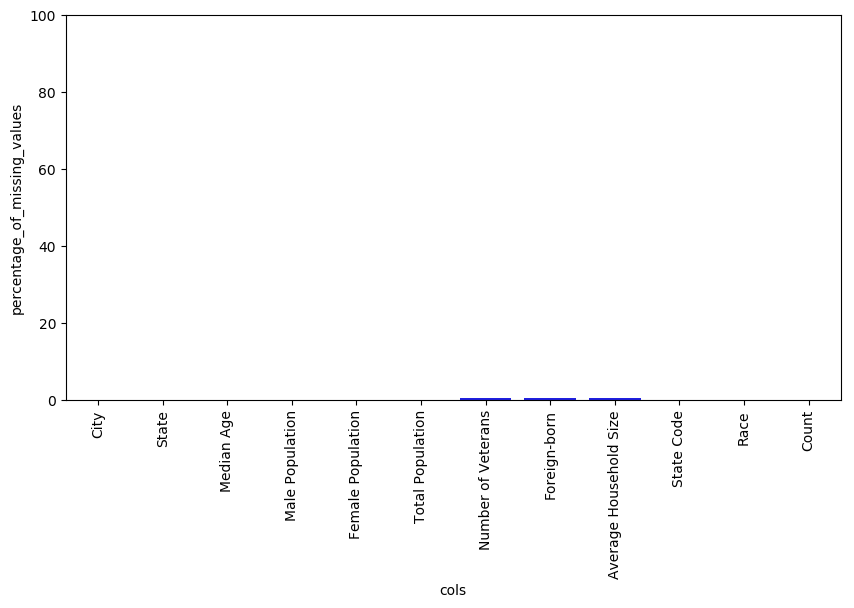

In [32]:
plot_nan_values(df_demographics)

#### Clean-up

Due to the very low amount of NaNs present in this dataset we are going to drop the records of these rows. 

In [33]:
# Dropping NaN columns

nan_columns = [
    'Male Population',
    'Female Population',
    'Number of Veterans',
    'Foreign-born',
    'Average Household Size'
]
clean_df_demographics = df_demographics.dropna(subset=nan_columns)

In [34]:
# Dropping duplicate rows

duplicate_columns = [
    'City', 
    'State', 
    'State Code', 
    'Race'
]


clean_df_demographics = clean_df_demographics.dropDuplicates(subset=duplicate_columns)

In [35]:
print(f'Number of records present in the raw demographics dataset: {df_demographics.count()}')
print(f'Number of records after cleaning: {clean_df_demographics.count()}')

Number of records present in the raw demographics dataset: 2891
Number of records after cleaning: 2875


The cleaning steps outlined above for the I94 inmigration dataset, the temperature dataset and the demographics dataset are encapsulated in the methods `clean_immigration_dataset`, `clean_temperature_dataset` and `clean_demographics_data` respectively that can be found in the helper code `./lib_spark.py`.

# Step 3: Data model definition

## Conceptual data model

Once the raw data is clean we can proceed to reorganize this information to make the data accessible to get insights. We are going to rearrange the data as a star-shaped schema.

1. **Fact table - I94 Inmigration**: this is the core of the data model and it contains data from inmigrants entering the USA
2. **Dimension table - Country**: this table is built from the global land temperature and part of the I94 inmigration dataset. It can be used to study correlations between global land temperatures and immigration to the USA
3. **Dimension table - Demographics**: this table is built from the demographics and the I94 inmigration dataset. It can be used to study correlations between the immigration to the USA with the demographic statistics in different USA cities.
4. **Dimension table - Visa**: this table is built from the immigration dataset. It can be used to retrieve statistics that link the incoming migaration to the USA with the visa os the migrants. 

The fact table is linked to the dimension tables via foreign keys.

## Extract Transform Load pipeline (ETL)

The ETL presented in this notebook will extract the raw data, apply the cleanup showed in Step 2 and re-organize this information in the data model detailed above. The pipeline will follow the below steps:

1. Load the datasets: Step 1
2. Clean the datasets: Step 2
3. Create the dimension tables (Country, Demographics and Visa)
4. Save the dimension tables (Country, Demographics and Visa)
5. Create the fact table (I94 Inmigration)
6. Save the fact table (I94 Inmigration)

# Step 4: Run the ETL to model the data



In [71]:
def create_immigration_calendar_dimension(
        df_inmigration = None, 
        output_data = None, 
        mode = 'overwrite'
    ):
    """
    This method is designed to create the immigration calendar dimension table that encapsulates the arrival date to the USA
    
    :param df_inmigration: I94 inmigration dataset
    :type pyspark.sql.DataFrame:
    :param output_data: path where the dimension dataframe will be saved in parquet format
    :type str:
    :param mode ('overwrite'): write mode of the output dataframe in parquet format
    :type str:
    :return pyspark.sql.DataFrame:
    """
    
    # arrival date in SAS format converted to datetime object
    udf_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    calendar_df = df_inmigration.select(['arrdate']).\
        withColumn('id', monotonically_increasing_id()).\
        withColumn('arrdate', udf_datetime(df_inmigration.arrdate)).distinct().\
        withColumn('arrival_day', dayofmonth('arrdate')).\
        withColumn('arrival_week', weekofyear('arrdate')).\
        withColumn('arrival_month', month('arrdate')).\
        withColumn('arrival_year', year('arrdate')).\
        withColumn('arrival_weekday', dayofweek('arrdate'))

    calendar_df = calendar_df.withColumnRenamed('arrdate', 'arrival_date')
    
    return calendar_df

In [72]:
def create_country_dimension(
        df_inmigration = None, 
        df_temperature = None, 
        output_data = None, 
        mode = 'overwrite'
    ):
    """
    This method is designed to create the country dimension table from the I94 inmigration and the globat temperature dataset

    :param df_inmigration: I94 inmigration dataset
    :type pyspark.sql.DataFrame:
    :param df_temperature: global temperature dataset
    :type pyspark.sql.DataFrame:
    :param output_data: path where the dimension dataframe will be saved in parquet format
    :type str:
    :param mode ('overwrite'): write mode of the output dataframe in parquet format
    :type str: 
    :return pyspark.sql.DataFrame:
    """

    @udf('string')
    def get_average_temperature(country_name = None):
        avg_temp = df_temperature_country[df_temperature_country['Country'] == country_name]['average_temperature']
        return str(avg_temp.iloc[0])
    
    @udf()
    def get_country_name(country_code = None):
        name = usa_codes[usa_codes['code'] == country_code]['Name'].iloc[0]
        return name.title()

    df_dim_country = df_inmigration.\
        select(['i94res']).distinct().\
        withColumnRenamed('i94res', 'country_code')

    usa_codes = pd.read_csv('i94res.csv')

    df_temperature_country = aggregate_temperature_data(df_temperature).toPandas()
    
    col_country_name = get_country_name(df_dim_country.country_code)
    col_country_avg_temperature = get_average_temperature(df_dim_country.country_code)

    df_dim_country = df_dim_country.\
        withColumn('country_name', col_country_name).\
        withColumn('average_temperature', col_country_avg_temperature)
    
    return df_dim_country

In [73]:
def create_visa_type_dimension(
        df_inmigration = None, 
        output_data = None, 
        mode = 'overwrite'
    ) -> None:
    """
    This method is designed to generate the visa dimension table. The I94 dimension data is used for this purpose.

    :param df_inmigration: I94 inmigration dataset
    :type pyspark.sql.DataFrame:
    :param output_data: path where the dimension dataframe will be saved in parquet format
    :type str:
    :param mode ('overwrite'): write mode of the output dataframe in parquet format
    :type str: 
    """

    df_dim_visa = df_inmigration.select(['visatype']).distinct()\
        .withColumn('visa_type_key', monotonically_increasing_id())

    return df_dim_visa

In [58]:
def create_demographic_dimension(
        df_inmigration = None, 
        output_data = None, 
        mode = 'overwrite'
    ) -> None:
    """
    This method is designed to generate the demographic dimension table. The I94 dimension data is used for this purpose.

    :param df_inmigration: I94 inmigration dataset
    :type pyspark.sql.DataFrame:
    :param output_data: path where the dimension dataframe will be saved in parquet format
    :type str:
    :param mode ('overwrite'): write mode of the output dataframe in parquet format
    :type str: 

    :return pyspark.sql.DataFrame:
    """
    
    df_demographic = df_inmigration.\
        withColumn('id', monotonically_increasing_id()).\
        withColumnRenamed('Median Age','median_age').\
        withColumnRenamed('Male Population', 'male_population').\
        withColumnRenamed('Female Population', 'female_population').\
        withColumnRenamed('Total Population', 'total_population').\
        withColumnRenamed('Number of Veterans', 'number_of_veterans').\
        withColumnRenamed('Foreign-born', 'foreign_born').\
        withColumnRenamed('Average Household Size', 'average_household_size').\
        withColumnRenamed('State Code', 'state_code')
    
    return df_demographic

Processing inmigration calendar dimension table

In [75]:
df_immigration_calendar_dim = create_immigration_calendar_dimension(df_inmigration = clean_df_inmigration)
df_immigration_calendar_dim.limit(5).toPandas()

,arrival_date,id,arrival_day,arrival_week,arrival_month,arrival_year,arrival_weekday
0,2016-04-02,658,2,13,4,2016,7
1,2016-04-02,951,2,13,4,2016,7
2,2016-04-03,1292,3,13,4,2016,1
3,2016-04-05,1934,5,14,4,2016,3
4,2016-04-05,2029,5,14,4,2016,3


In [76]:
output_dir = 'tables'
output_path = os.path.join(output_dir, 'dim_inmigration_calendar')
partition_columns = ['arrival_year', 'arrival_month', 'arrival_week']
df_immigration_calendar_dim.write.parquet(output_path, partitionBy = partition_columns, mode = 'overwrite')

Processing country dimension table

In [ ]:
df_country_dim = create_country_dimension(df_inmigration = clean_df_inmigration, df_temperature = clean_df_temperature)
df_country_dim.limit(5).toPandas()

In [ ]:
output_dir = 'tables'
output_path = os.path.join(output_dir, 'dim_country')
df_country_dim.write.parquet(output_path, mode = 'overwrite')

Processing visa type dimension table

In [83]:
df_visa_dim = create_visa_type_dimension(df_inmigration = clean_df_inmigration)
df_visa_dim.limit(5).toPandas()

,visatype,visa_type_key
0,F2,103079215104
1,GMB,352187318272
2,B2,369367187456
3,F1,498216206336
4,CPL,601295421440


In [84]:
output_dir = 'tables'
output_path = os.path.join(output_dir, 'dim_visa')
df_visa_dim.write.parquet(output_path, mode = 'overwrite')

Processing demographics dimension table

In [85]:
df_demographic = create_demographic_dimension(clean_df_inmigration, output_data)
df_demographic.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype,id
0,299.0,2016.0,4.0,103.0,103.0,NYC,20545.0,1.0,NY,20550.0,...,O,M,1962.0,06292016,None,OS,5.542587e+10,00087,WT,0
1,305.0,2016.0,4.0,103.0,103.0,NYC,20545.0,1.0,NY,20555.0,...,O,M,1953.0,06292016,None,OS,5.542582e+10,00087,WT,1
2,496.0,2016.0,4.0,103.0,103.0,CHI,20545.0,1.0,IL,20548.0,...,O,M,1952.0,06292016,None,OS,5.542862e+10,00065,WB,2
3,558.0,2016.0,4.0,103.0,103.0,SFR,20545.0,1.0,CA,20547.0,...,O,M,1974.0,06292016,M,LH,5.543331e+10,00454,WB,3
4,596.0,2016.0,4.0,103.0,103.0,NAS,20545.0,1.0,FL,20547.0,...,N,M,1992.0,06292016,M,UP,5.540611e+10,00221,WT,4


In [86]:
output_dir = 'tables'
output_path = os.path.join(output_dir, 'dim_demographic')
df_demographic.write.parquet(output_path, mode = 'overwrite')

In [ ]:
def create_immigration_fact_table(df, output_data):
    """This function creates an country dimension from the immigration and global land temperatures data.
    
    :param df: spark dataframe of immigration events
    :param visa_type_df: spark dataframe of global land temperatures data.
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing calendar dimension
    """
    # get visa_type dimension
    dim_df = get_visa_type_dimension(output_data).toPandas()
    
    @udf('string')
    def get_visa_key(visa_type):
        """user defined function to get visa key
        
        :param visa_type: US non-immigrant visa type
        :return: corresponding visa key
        """
        key_series = dim_df[dim_df['visatype']==visa_type]['visa_type_key']
        
        if not key_series.empty:
            return str(key_series.iloc[0])
        
        return None
    
    # create a udf to convert arrival date in SAS format to datetime object
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    # rename columns to align with data model
    df = df.withColumnRenamed('cicid','record_id') \
            .withColumnRenamed('i94res', 'country_residence_code') \
            .withColumnRenamed('i94addr', 'state_code') 
    
    # create visa_type key
    df = df.withColumn('visa_type_key', get_visa_key('visatype'))
    
    # convert arrival date into datetime object
    df = df.withColumn("arrdate", get_datetime(df.arrdate))
    
    # write dimension to parquet file
    df.write.parquet(output_data + "immigration_fact", mode="overwrite")
    
    return df

# Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

##### Create the immigration calendar dimension table
---

In [51]:
def create_immigration_fact_table(df, output_data):
    """This function creates an country dimension from the immigration and global land temperatures data.
    
    :param df: spark dataframe of immigration events
    :param visa_type_df: spark dataframe of global land temperatures data.
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing calendar dimension
    """
    # get visa_type dimension
    dim_df = get_visa_type_dimension(output_data).toPandas()
    
    @udf('string')
    def get_visa_key(visa_type):
        """user defined function to get visa key
        
        :param visa_type: US non-immigrant visa type
        :return: corresponding visa key
        """
        key_series = dim_df[dim_df['visatype']==visa_type]['visa_type_key']
        
        if not key_series.empty:
            return str(key_series.iloc[0])
        
        return None
    
    # create a udf to convert arrival date in SAS format to datetime object
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    # rename columns to align with data model
    df = df.withColumnRenamed('cicid','record_id') \
            .withColumnRenamed('i94res', 'country_residence_code') \
            .withColumnRenamed('i94addr', 'state_code') 
    
    # create visa_type key
    df = df.withColumn('visa_type_key', get_visa_key('visatype'))
    
    # convert arrival date into datetime object
    df = df.withColumn("arrdate", get_datetime(df.arrdate))
    
    # write dimension to parquet file
    df.write.parquet(output_data + "immigration_fact", mode="overwrite")
    
    return df

In [52]:
immigration_fact_df = create_immigration_fact_table(new_immigration_df, output_data)

In [ ]:
def run_pipeline():
    # load data
    
    # run cleaning functions
    
    # create fact and dimension tables
    
    

#### 4.2 Data Quality Checks
The data quality checks ensures that the ETL has created fact and dimension tables with adequate records. 

In [47]:
table_dfs = {
    'immigration_fact': immigration_fact_df,
    'visa_type_dim': visatype_df,
    'calendar_dim': calendar_df,
    'usa_demographics_dim': demographics_dim_df,
    'country_dim': country_dim_f
}
for table_name, table_df in table_dfs.items():
    # quality check for table
    etl_functions.quality_checks(table_df, table_name)

Data quality check passed for immigration_fact with 3,096,313 records.
Data quality check passed for visa_type_dim with 17 records.
Data quality check passed for calendar_dim with 30 records.
Data quality check passed for usa_demographics_dim with 2,875 records.
Data quality check passed for country_dim with 229 records.


INCLUIR ARRIBA

##### Fact Table

<table align="left">
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
 <tr><td>record_id</td><td>Unique record ID</td></tr>
 <tr><td>country_residence_code</td><td>3 digit code for immigrant country of residence </td></tr>    
 <tr><td>visa_type_key</td><td>A numerical key that links to the visa_type dimension table</td></tr>
 <tr><td>state_code</td><td>US state of arrival</td></tr>
 <tr><td>i94yr</td><td>4 digit year</td></tr>
 <tr><td>i94mon</td><td>Numeric month</td></tr>
 <tr><td>i94port</td><td>Port of admission</td></tr>
 <tr><td>arrdate</td><td>Arrival Date in the USA</td></tr>
 <tr><td>i94mode</td><td>Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)</td></tr>
 <tr><td>i94addr</td><td>USA State of arrival</td></tr>
 <tr><td>depdate</td><td>Departure Date from the USA</td></tr>
 <tr><td>i94bir</td><td>Age of Respondent in Years</td></tr>
 <tr><td>i94visa</td><td>Visa codes collapsed into three categories</td></tr>
 <tr><td>count</td><td>Field used for summary statistics</td></tr>
 <tr><td>dtadfile</td><td>Character Date Field - Date added to I-94 Files</td></tr>
 <tr><td>visapost</td><td>Department of State where where Visa was issued </td></tr>
 <tr><td>occup</td><td>Occupation that will be performed in U.S</td></tr>
 <tr><td>entdepa</td><td>Arrival Flag - admitted or paroled into the U.S.</td></tr>
 <tr><td>entdepd</td><td>Departure Flag - Departed, lost I-94 or is deceased</td></tr>
 <tr><td>entdepu</td><td>Update Flag - Either apprehended, overstayed, adjusted to perm residence</td></tr>
 <tr><td>matflag</td><td>Match flag - Match of arrival and departure records</td></tr>
 <tr><td>biryear</td><td>4 digit year of birth</td></tr>
 <tr><td>dtaddto</td><td>Character Date Field - Date to which admitted to U.S. (allowed to stay until)</td></tr>
 <tr><td>gender</td><td>Non-immigrant sex</td></tr>
</table>

##### Country Dimension Table - data dictionary
<p>  
<i>The country code and country_name fields come from the labels description SAS file while the average_temperature data comes from the global land temperature by cities data.</i>
</p>
<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">country_code</td><td class="tg-0pky">Unique country code</td></tr>
 <tr><td class="tg-0pky">country_name</td><td class="tg-0pky">Name of country</td></tr>    
 <tr><td class="tg-0pky">average_temperature</td><td class="tg-0pky">Average temperature of country</td></tr>
</table>

##### Visa Type Dimension Table - data dictionary
<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">visa_type_key</td><td class="tg-0pky">Unique id for each visa issued</td></tr>
 <tr><td class="tg-0pky">visa_type</td><td class="tg-0pky">Name of visa</td></tr>
</table>

 ##### Immigration Calendar Dimension Table - data dictionary
<p>
<i>The whole of this dataset comes from the immigration dataset.</i>
</p>
<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">id</td><td class="tg-0pky">Unique id</td></tr>
 <tr><td class="tg-0pky">arrdate</td><td class="tg-0pky">Arrival date into US</td></tr>    
 <tr><td class="tg-0pky">arrival_year</td><td class="tg-0pky">Arrival year into US</td></tr>
 <tr><td class="tg-0pky">arrival_month</td><td class="tg-0pky">Arrival MonthS</td></tr>
 <tr><td class="tg-0pky">arrival_day</td><td class="tg-0pky">Arrival Day</td></tr>
 <tr><td class="tg-0pky">arrival_week</td><td class="tg-0pky">Arrival Week</td></tr>
 <tr><td class="tg-0pky">arrival_weekday</td><td class="tg-0pky">Arrival WeekDay</td></tr>
</table>

##### US Demographics Dimension Table - data dictionary
<p>
<i>The whole of this dataset comes from the us cities demographics data.</i>
</p>

<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">id</td><td class="tg-0pky">Record id</td>
 <tr><td class="tg-0pky">state_code</td><td class="tg-0pky">US state code </td>
 <tr><td class="tg-0pky">City</td><td class="tg-0pky">City Name</td>
 <tr><td class="tg-0pky">State</td><td class="tg-0pky">US State where city is located</td>
 <tr><td class="tg-0pky">Median Age</td><td class="tg-0pky">Median age of the population</td>
 <tr><td class="tg-0pky">Male Population</td><td class="tg-0pky">Count of male population</td>
 <tr><td class="tg-0pky">Female Population</td><td class="tg-0pky">Count of female population</td>
 <tr><td class="tg-0pky">Total Population</td><td class="tg-0pky">Count of total population</td>
 <tr><td class="tg-0pky">Number of Veterans</td><td class="tg-0pky">Count of total Veterans</td>
 <tr><td class="tg-0pky">Foreign born</td><td class="tg-0pky">Count of residents of the city that were not born in the city</td>
 <tr><td class="tg-0pky">Average Household Size</td><td class="tg-0pky">Average city household size</td>
 <tr><td class="tg-0pky">Race</td><td class="tg-0pky">Respondent race</td>
 <tr><td class="tg-0pky">Count</td><td class="tg-0pky">Count of city's individual per race</td>
</table>

#### Step 5: Complete Project Write Up
* Rationale for the choice of tools and technologies for the project
    * Apache spark was used because of:
        * it's ability to handle multiple file formats with large amounts of data. 
        * Apache Spark offers a lightning-fast unified analytics engine for big data.
        * Spark has easy-to-use APIs for operating on large datasets
* Propose how often the data should be updated and why.
    * The current I94 immigration data is updated monthly, and hence the data will be updated monthly. 
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
     * Spark can handle the increase but we would consider increasing the number of nodes in our cluster.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     * In this scenario, Apache Airflow will be used to schedule and run data pipelines.
 * The database needed to be accessed by 100+ people.
     * In this scenario, we would move our analytics database into Amazon Redshift. 